<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#resnet50" data-toc-modified-id="resnet50-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>resnet50</a></span></li><li><span><a href="#Densenet121" data-toc-modified-id="Densenet121-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Densenet121</a></span></li><li><span><a href="#VGG16" data-toc-modified-id="VGG16-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>VGG16</a></span></li><li><span><a href="#My-Rand" data-toc-modified-id="My-Rand-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>My Rand</a></span></li></ul></div>

# Data
- https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/CADDPD

Ci = cirrus; Cs = cirrostratus; Cc = cirrocumulus; Ac = altocumulus; As = altostratus; Cu = cumulus; Cb = cumulonimbus; Ns = nimbostratus; Sc = stratocumulus; St = stratus; Ct = contrail

In [1]:
from fastai.vision import *

In [2]:
os.environ['TORCH_HOME'] = '/media/subhaditya/DATA/COSMO/Datasets-Useful'

In [3]:
data = (ImageList.from_folder(
    Path('data/CCSN/')).split_by_rand_pct().label_from_folder().transform(
        get_transforms(
            do_flip=True,
            flip_vert=False,
            max_rotate=5.0,
            max_zoom=1.1,
            max_lighting=0.2,
            max_warp=0.0,
            p_affine=0.75,
            p_lighting=0.75,
        ),
        size=128).databunch(bs=64)).normalize(imagenet_stats)

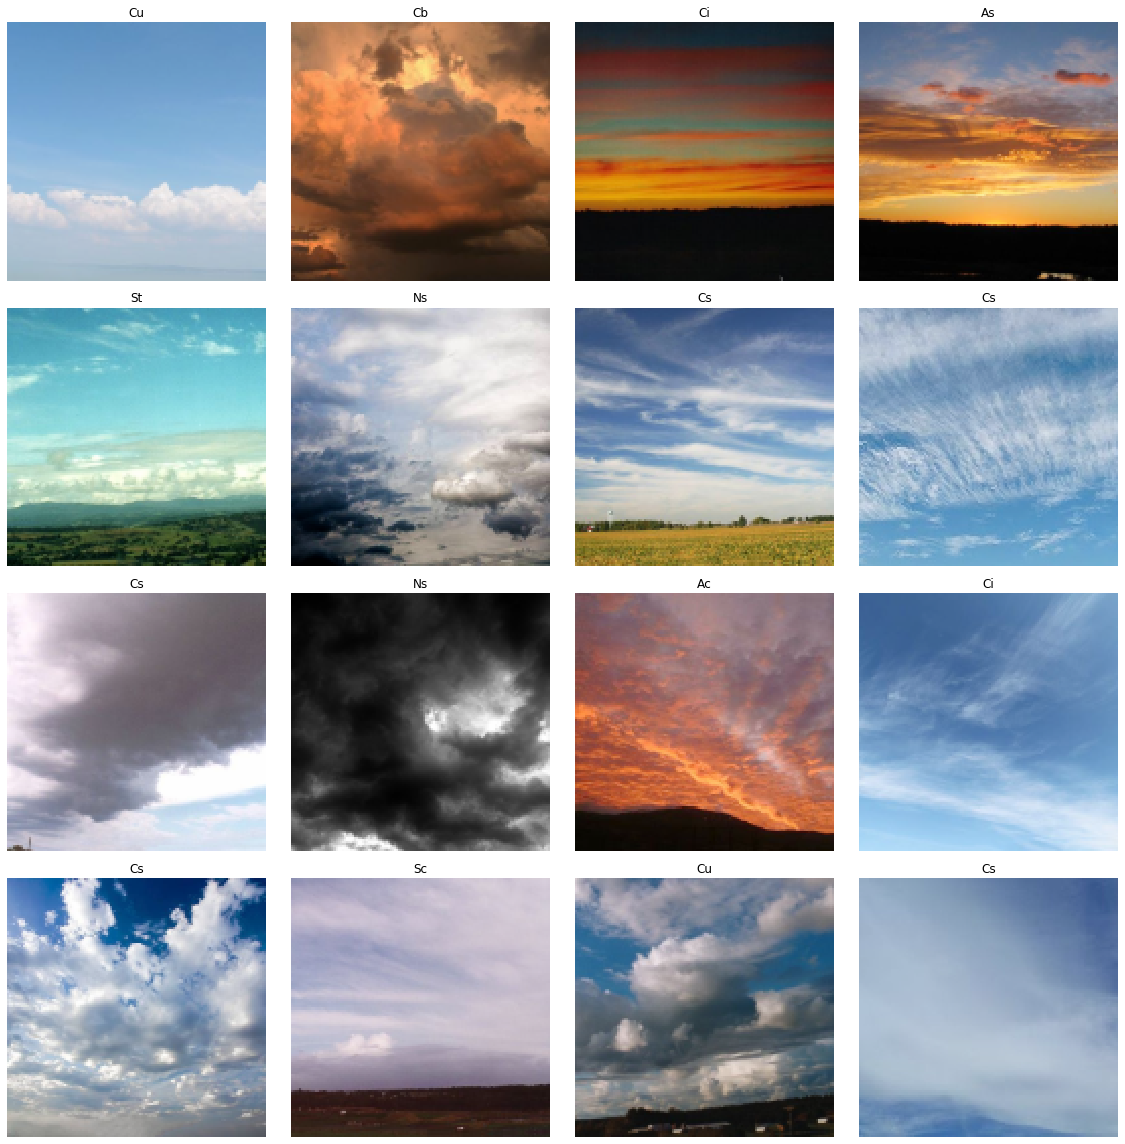

In [4]:
data.show_batch(4)

In [5]:
data.c

11

In [6]:
data

ImageDataBunch;

Train: LabelList (2035 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Ac,Ac,Ac,Ac,Ac
Path: data/CCSN;

Valid: LabelList (508 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Sc,Cu,Sc,Cc,Sc
Path: data/CCSN;

Test: None

# Inception+resnet

In [7]:
learn = None
gc.collect()

35718

In [8]:
class InceptionA(nn.Module):
    def __init__(self, in_channels):
        super(InceptionA, self).__init__()
        self.branch1x1 = nn.Conv2d(in_channels, 16, kernel_size=1)

        self.branch5x5_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch5x5_2 = nn.Conv2d(16, 24, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch3x3dbl_2 = nn.Conv2d(16, 24, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = nn.Conv2d(24, 24, kernel_size=3, padding=1)

        self.branch_pool = nn.Conv2d(in_channels, 24, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

In [54]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 2)
        self.conv2 = nn.Conv2d(88, 64, 2)
        self.conv3 = nn.Conv2d(88, 20, 2)
        #         self.conv4 = nn.Conv2d(88, 20, 2)
        self.mp = nn.MaxPool2d(2)
        self.fc = nn.Linear(19800, 11)
        self.incept1 = InceptionA(in_channels=128)
        self.incept2 = InceptionA(in_channels=64)
        self.incept3 = InceptionA(in_channels=20)
        self.rb = res_block(128)
        self.rb2 = res_block(64)
        self.rb3 = res_block(20)
#         self.sm = F.log_softmax(10)

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = self.rb(x)
        x = self.incept1(x)
        

        x = F.relu(self.mp(self.conv2(x)))
        x = self.rb2(x)
        x = self.incept2(x)
        

        x = F.relu(self.mp(self.conv3(x)))
        x = self.rb3(x)
        x = self.incept3(x)
        

        x = x.view(in_size, -1)
        x = self.fc(x)
        
        return F.softmax(x,dim=1)

In [55]:
learn = None
gc.collect()

784

In [56]:
learn = Learner(
    data,
    Model(),
    metrics=[accuracy, error_rate],
    opt_func=AdamW,
    callback_fns=ShowGraph,
).to_fp16()

In [57]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


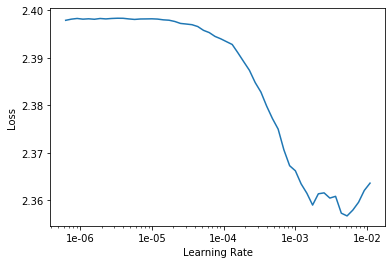

In [58]:
learn.recorder.plot()

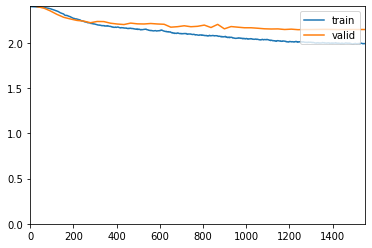

In [59]:
learn.fit_one_cycle(50, 1e-04)

In [60]:
learn.save('resIn-1')

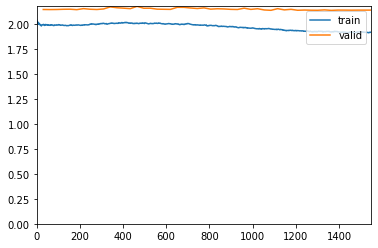

In [62]:
learn.unfreeze()
learn.fit_one_cycle(50, 1e-04)

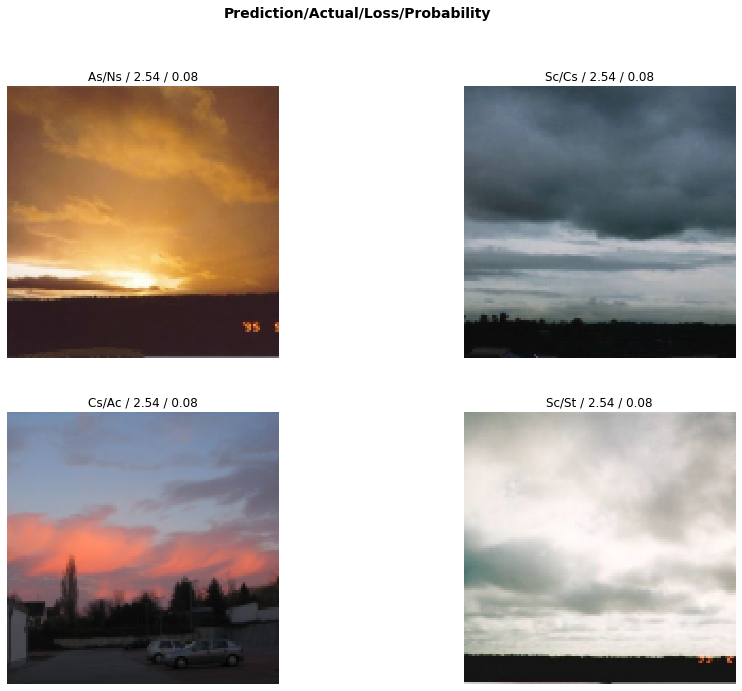

In [63]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()
interp.plot_top_losses(4, figsize=(15, 11))

# Densenet121

In [65]:
learn = None
gc.collect()

20

In [18]:
learn = cnn_learner(data, models.densenet121, metrics=[accuracy, error_rate])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /media/subhaditya/DATA/COSMO/Datasets-Useful/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:05<00:00, 5.50MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


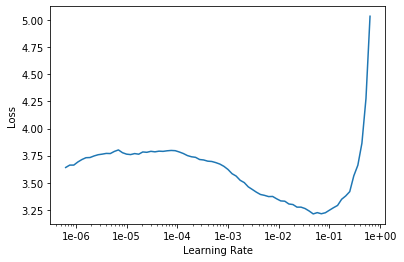

In [19]:
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(10, 1e-04)

In [23]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-04)

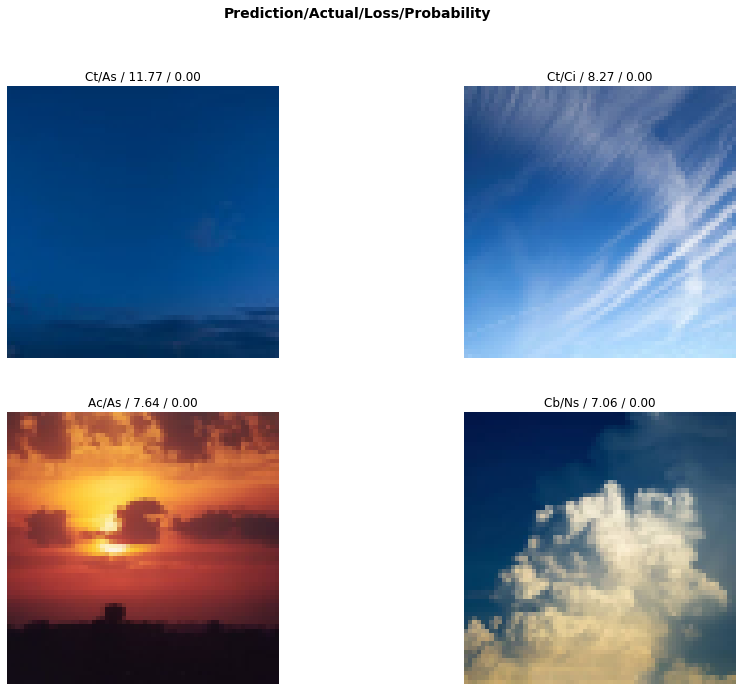

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()
interp.plot_top_losses(4, figsize=(15, 11))

In [25]:
learn.unfreeze()
learn.fit_one_cycle(30, 1e-04)

In [26]:
learn.save('stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


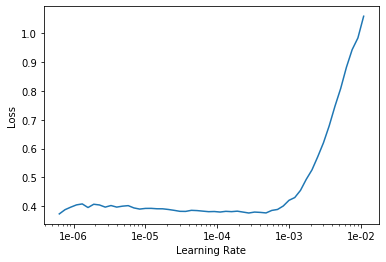

In [27]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.unfreeze()
learn.fit_one_cycle(30, 1e-04)

KeyboardInterrupt: 

# VGG16

In [5]:
data.c

11

In [17]:
learn = None
gc.collect()

91

In [14]:
learn = cnn_learner(data, models.vgg16_bn, metrics=[accuracy, error_rate]).to_fp32()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


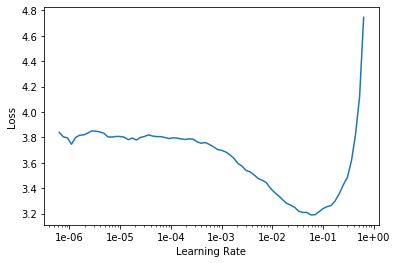

In [7]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.load('vgg-s2')

Learner(data=ImageDataBunch;

Train: LabelList (2035 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Ac,Ac,Ac,Ac,Ac
Path: data/CCSN;

Valid: LabelList (508 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
As,Cb,Cb,Ns,Cb
Path: data/CCSN;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_si

In [16]:
learn.unfreeze()
learn.fit_one_cycle(1, 3e-03)

KeyboardInterrupt: 

In [140]:
learn.save('vgg-s3')

In [141]:
time.sleep(60)

In [12]:
learn.unfreeze()
learn.fit_one_cycle(200, 3e-03)

In [142]:
learn.save('vgg-s3')

In [156]:
learn.load('vgg-s2')

Learner(data=ImageDataBunch;

Train: LabelList (2035 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Ac,Ac,Ac,Ac,Ac
Path: data/CCSN;

Valid: LabelList (508 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Cs,Cc,St,Sc,Sc
Path: data/CCSN;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_si

In [157]:
learn.validate()

[0.5327904, tensor(0.8701), tensor(0.1299)]

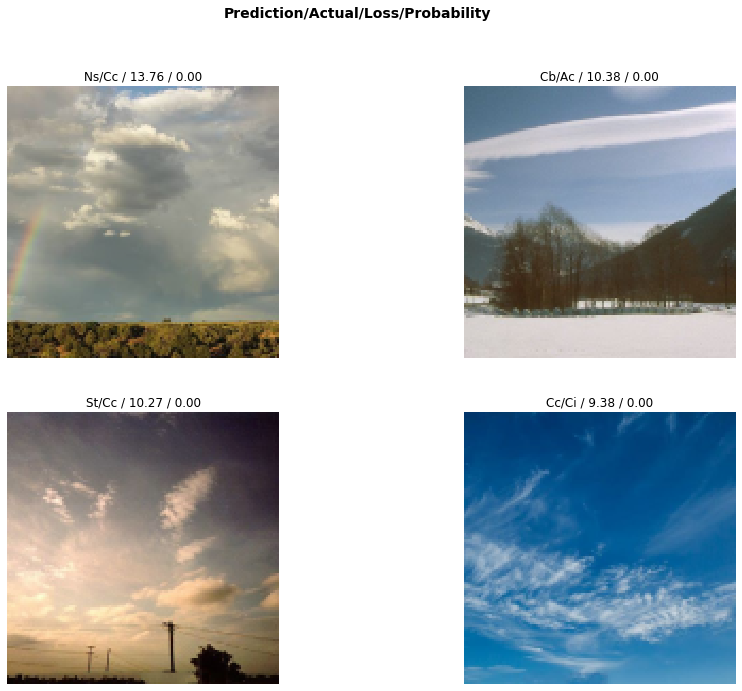

In [144]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()
interp.plot_top_losses(4, figsize=(15, 11))

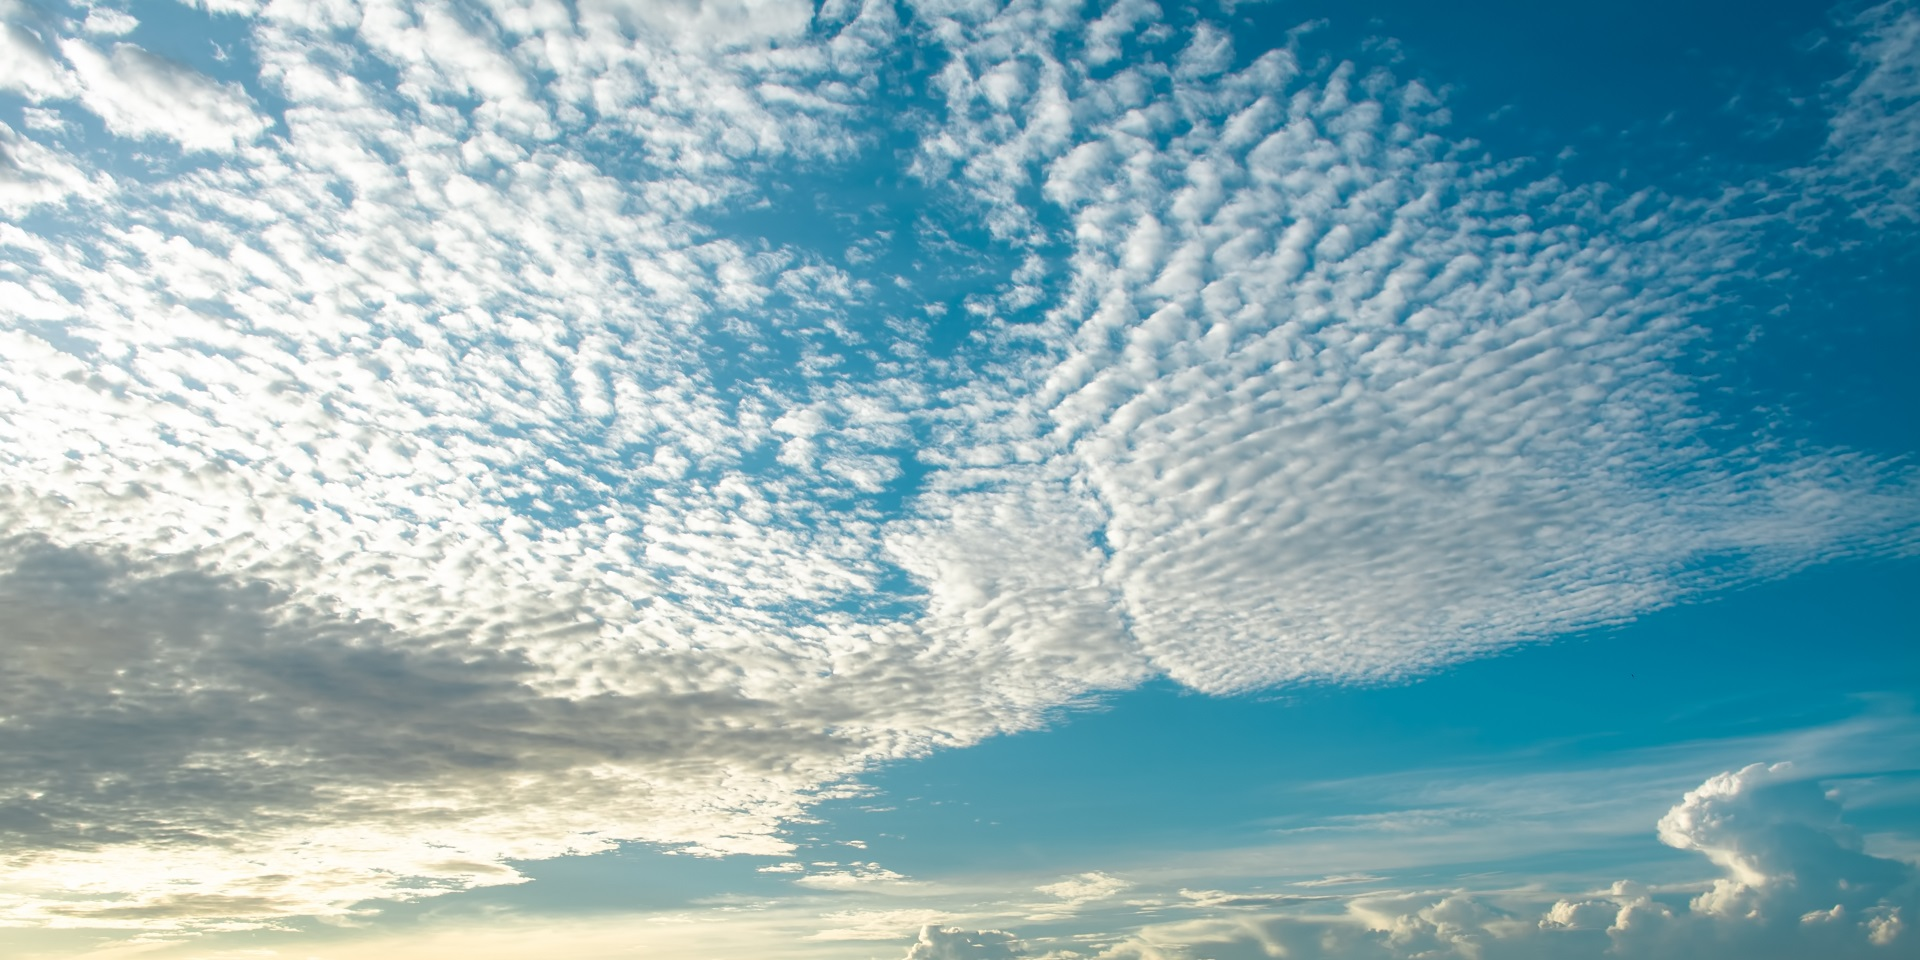

In [68]:
open_image('ac.jpg')

In [71]:
learn.predict(open_image('test.jpeg'))

(Category Cc,
 tensor(3),
 tensor([0.0786, 0.0786, 0.0786, 0.2137, 0.0786, 0.0786, 0.0786, 0.0786, 0.0786,
         0.0786, 0.0786]))

# My Rand

In [60]:
learn = None
gc.collect()

20

In [80]:
def conv_layer_d(ni, nf):
    return nn.Sequential(*[
        nn.Conv2d(ni, nf, 3, 2, 1),
        nn.BatchNorm2d(nf),
        nn.ReLU(inplace=True),
        nn.Conv2d(nf, nf, 3, 2, 1),
        nn.BatchNorm2d(nf),
        nn.Conv2d(nf, nf, 1, 2),
        nn.BatchNorm2d(nf)
    ])

In [81]:
def conv2_rep(no, ni, nf):
    return nn.Sequential(*[conv_layer_d(ni, nf) for x in range(no)])

In [82]:
def batch_drop_lin(ni, nf):
    return nn.Sequential(
        *[nn.BatchNorm1d(ni),
          nn.Dropout(.50),
          nn.Linear(ni, nf)])

SequentialEx(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): MergeLayer()
  )
)

In [120]:
model = nn.Sequential(*[
    conv_layer(3,128),
    nn.AdaptiveMaxPool2d(1),
    conv2_rep(3,128, 128),
    conv_layer_d(128, 128),
    nn.AdaptiveMaxPool2d(1),
    res_block(128),
    conv2_rep(3, 128, 128),
    conv_layer_d(128, 256),
    nn.AdaptiveMaxPool2d(1),
    
    conv2_rep(5, 256, 256),
#     res_block(256),
    conv_layer_d(256, 512),
    nn.AdaptiveMaxPool2d(1),
    conv2_rep(2, 512, 512),
    nn.AdaptiveMaxPool2d(1),
    Flatten(),
#     res_block(512),
    batch_drop_lin(512, 256),
    nn.ReLU(inplace=True),
#     res_block(256),
    batch_drop_lin(256, 128),
    nn.ReLU(inplace=True),
#     res_block(128),
    batch_drop_lin(128, 64),
    nn.ReLU(inplace=True),
#     res_block(64),
    batch_drop_lin(64, 11),
    Flatten()
]
)

In [123]:
learn = Learner(data, model, metrics=[accuracy, error_rate]).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


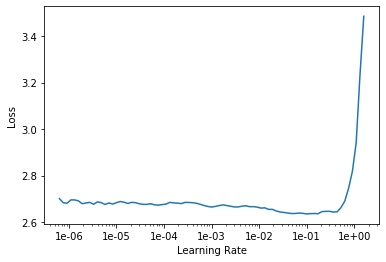

In [124]:
learn.lr_find()
learn.recorder.plot()

In [125]:
learn.unfreeze()
learn.fit_one_cycle(30, 1e-3)

In [126]:
import time
time.sleep(60)


In [127]:
learn.save('mynet-1')

In [128]:
learn.unfreeze()
learn.fit_one_cycle(30, 1e-3)

In [129]:
learn.save('mynet-2')

In [130]:
time.sleep(60)

In [131]:
learn.unfreeze()
learn.fit_one_cycle(60, 1e-3)

In [132]:
learn.unfreeze()
learn.fit_one_cycle(100, 1e-3)

KeyboardInterrupt: 